# Tuning Example

This notebook demonstrates hyperparameter tuning

It uses the [CHI Papers data](https://cs533.ekstrandom.net/resources/tutorials/fetchchipapers/).

All of these are going to optimize for **accuracy**, the metric returned by the `score` function on a classifier.

## Setup

scikit-optimize isn't in Anaconda, so we'll install it from Pip:

In [1]:
%pip install scikit-optimize

Note: you may need to restart the kernel to use updated packages.


Import our general PyData packages:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

And some SciKit Learn:

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
from sklearn.naive_bayes import MultinomialNB

And finally the Bayesian optimizer:

In [4]:
from skopt import BayesSearchCV

We want predictable randomness:

In [5]:
rng = np.random.RandomState(20201130)

In this notebook, I have SciKit-Learn run some tasks in parallel.  Let's configure the (max) number of parallel tasks in one place, so you can easily adjust it based on your computer's capacity:

In [6]:
NJOBS = 8

## Load Data

We're going to load the CHI Papers data from the CSV file, output by the other notebook:

In [7]:
papers = pd.read_csv('chi-papers.csv', encoding='utf8')
papers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13422 entries, 0 to 13421
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        13333 non-null  object
 1   title     13416 non-null  object
 2   authors   13416 non-null  object
 3   date      13422 non-null  object
 4   abstract  12926 non-null  object
 5   year      13422 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 629.3+ KB


Let's treat empty abstracts as empty strings:

In [8]:
papers['abstract'].fillna('', inplace=True)
papers['title'].fillna('', inplace=True)

For our purposes we want all text - the title and the abstract.  We will join them with a space, so we don't fuse the last word of the title to the first word of the abstract:

In [9]:
papers['all_text'] = papers['title'] + ' ' + papers['abstract']

We're going to classify papers as *recent* if they're newer than 2005:

In [10]:
papers['IsRecent'] = papers['year'] > 2005

And make training and test data:

In [11]:
train, test = train_test_split(papers, test_size=0.2, random_state=rng)

Let's make a function for measuring accuracy:

In [12]:
def measure(model, text='all_text'):
    preds = model.predict(test[text])
    print(classification_report(test['IsRecent'], preds))

And look at the class distribution:

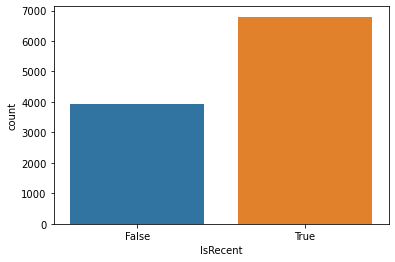

In [13]:
sns.countplot(train['IsRecent'])

## Classifying New Papers

Let's classify recent papers with k-NN on TF-IDF vectors:

In [14]:
base_knn = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', lowercase=True, max_features=10000)),
    ('class', KNeighborsClassifier(5))
])
base_knn.fit(train['all_text'], train['IsRecent'])

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('class', KNeighborsClassifier())])

And measure it:

In [15]:
measure(base_knn)

              precision    recall  f1-score   support

       False       0.39      1.00      0.56      1034
        True       0.91      0.01      0.02      1651

    accuracy                           0.39      2685
   macro avg       0.65      0.51      0.29      2685
weighted avg       0.71      0.39      0.23      2685



## Tune the Neighborhood

Let's tune the neighborhood with a grid search:

In [16]:
tune_knn = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', lowercase=True, max_features=10000)),
    ('class', GridSearchCV(KNeighborsClassifier(), param_grid={
        'n_neighbors': [1, 2, 3, 5, 7, 10]
    }, n_jobs=NJOBS))
])
tune_knn.fit(train['all_text'], train['IsRecent'])

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('class',
                 GridSearchCV(estimator=KNeighborsClassifier(), n_jobs=8,
                              param_grid={'n_neighbors': [1, 2, 3, 5, 7,
                                                          10]}))])

What did it pick?

In [17]:
tune_knn.named_steps['class'].best_params_

{'n_neighbors': 10}

And measure it:

In [18]:
measure(tune_knn)

              precision    recall  f1-score   support

       False       0.51      0.90      0.65      1034
        True       0.87      0.45      0.60      1651

    accuracy                           0.62      2685
   macro avg       0.69      0.67      0.62      2685
weighted avg       0.73      0.62      0.62      2685



## SVD Neighborhood

Let's set up SVD-based neighborhood, and use random search to search both the latent feature count and the neighborhood size:

In [19]:
svd_knn_inner = Pipeline([
    ('latent', TruncatedSVD(random_state=rng)),
    ('class', KNeighborsClassifier())
])
svd_knn = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('class', RandomizedSearchCV(svd_knn_inner, param_distributions={
        'latent__n_components': stats.randint(1, 50),
        'class__n_neighbors': stats.randint(1, 25)
    }, n_iter=60, n_jobs=NJOBS, random_state=rng))
])
svd_knn.fit(train['all_text'], train['IsRecent'])

Pipeline(steps=[('vectorize', TfidfVectorizer(stop_words='english')),
                ('class',
                 RandomizedSearchCV(estimator=Pipeline(steps=[('latent',
                                                               TruncatedSVD(random_state=RandomState(MT19937) at 0x26BB86DF140)),
                                                              ('class',
                                                               KNeighborsClassifier())]),
                                    n_iter=60, n_jobs=8,
                                    param_distributions={'class__n_neighbors': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026BB8B0BEB0>,
                                                         'latent__n_components': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000026BB945A070>},
                                    random_state=RandomState(MT19937) at 0x26BB86DF140))])

What parameters did we pick?

In [20]:
svd_knn['class'].best_params_

{'class__n_neighbors': 21, 'latent__n_components': 21}

And measure it on the test data:

In [21]:
measure(svd_knn)

              precision    recall  f1-score   support

       False       0.75      0.47      0.58      1034
        True       0.73      0.90      0.81      1651

    accuracy                           0.74      2685
   macro avg       0.74      0.69      0.69      2685
weighted avg       0.74      0.74      0.72      2685



## SVD with scikit-optimize

Now let's cross-validate with SciKit-Optimize:

In [22]:
svd_knn_inner = Pipeline([
    ('latent', TruncatedSVD()),
    ('class', KNeighborsClassifier())
])
svd_bayes_knn = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('class', BayesSearchCV(svd_knn_inner, {
        'latent__n_components': (1, 50),
        'class__n_neighbors': (1, 25)
    }, n_jobs=NJOBS, random_state=rng))
])
svd_bayes_knn.fit(train['all_text'], train['IsRecent'])

C:\Users\michaelekstrand\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\michaelekstrand\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\michaelekstrand\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\michaelekstrand\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\michaelekstrand\Anaconda3\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("

Pipeline(steps=[('vectorize', TfidfVectorizer(stop_words='english')),
                ('class',
                 BayesSearchCV(estimator=Pipeline(steps=[('latent',
                                                          TruncatedSVD()),
                                                         ('class',
                                                          KNeighborsClassifier())]),
                               n_jobs=8,
                               random_state=RandomState(MT19937) at 0x26BB86DF140,
                               search_spaces={'class__n_neighbors': (1, 25),
                                              'latent__n_components': (1,
                                                                       50)}))])

What parameters did we pick?

In [23]:
svd_bayes_knn['class'].best_params_

OrderedDict([('class__n_neighbors', 25), ('latent__n_components', 20)])

And measure it:

In [24]:
measure(svd_bayes_knn)

              precision    recall  f1-score   support

       False       0.74      0.43      0.55      1034
        True       0.72      0.91      0.80      1651

    accuracy                           0.72      2685
   macro avg       0.73      0.67      0.67      2685
weighted avg       0.73      0.72      0.70      2685



## Naive Bayes

Let's give the Naive Bayes classifier a whirl:

In [25]:
nb = Pipeline([
    ('vectorize', TfidfVectorizer(stop_words='english', lowercase=True, max_features=10000)),
    ('class', MultinomialNB())
])
nb.fit(train['all_text'], train['IsRecent'])

Pipeline(steps=[('vectorize',
                 TfidfVectorizer(max_features=10000, stop_words='english')),
                ('class', MultinomialNB())])

In [26]:
measure(nb)

              precision    recall  f1-score   support

       False       0.89      0.50      0.64      1034
        True       0.75      0.96      0.85      1651

    accuracy                           0.78      2685
   macro avg       0.82      0.73      0.74      2685
weighted avg       0.81      0.78      0.77      2685



## Summary Accuracy

What does our test accuracy look like for our various classifiers?

In [27]:
models = {
    'kNN': base_knn,
    'kNN-CV': tune_knn,
    'kNN-SVD-Rand': svd_knn,
    'kNN-SVD-Bayes': svd_bayes_knn,
    'NB': nb
}

In [28]:
all_preds = pd.DataFrame()
for name, model in models.items():
    all_preds[name] = model.predict(test['all_text'])

In [29]:
acc = all_preds.apply(lambda ds: accuracy_score(test['IsRecent'], ds))
acc

kNN              0.391806
kNN-CV           0.623836
kNN-SVD-Rand     0.735940
kNN-SVD-Bayes    0.724022
NB               0.783240
dtype: float64

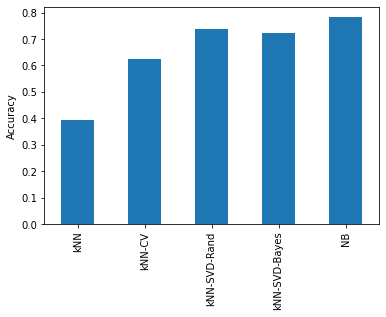

In [30]:
acc.plot.bar()
plt.ylabel('Accuracy')
plt.show()